In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

dataset_path = "/content/drive/My Drive/course data/yolo models"
print("Contents of the Dataset Folder:")
print(os.listdir(dataset_path))

Contents of the Dataset Folder:
['palm.pt', 'tongue.pt', 'eye.pt', 'fingernail.pt']


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Load the labels CSV
labels_path = '/content/drive/My Drive/course data/body part combine/labels.csv'
labels = pd.read_csv(labels_path)

# Check for missing values
print(labels.isnull().sum())  # Ensure no missing values

# Perform train-test split (80% train + val, 20% test)
train_val, test = train_test_split(
    labels,
    test_size=0.2,
    stratify=None,  # No binning; stratify=None since regression doesn't require bins
    random_state=42
)

# Further split train_val into train (80%) and validation (20%)
train, val = train_test_split(
    train_val,
    test_size=0.2,
    stratify=None,  # No stratification
    random_state=42
)

# Save the splits
save_dir = os.path.dirname(labels_path)
train.to_csv(os.path.join(save_dir, 'train_labels.csv'), index=False)
val.to_csv(os.path.join(save_dir, 'val_labels.csv'), index=False)
test.to_csv(os.path.join(save_dir, 'test_labels.csv'), index=False)

print("Splits saved in the same directory as labels.csv")


filename      0
hemoglobin    0
age           0
gender        0
body_part     0
dtype: int64
Splits saved in the same directory as labels.csv


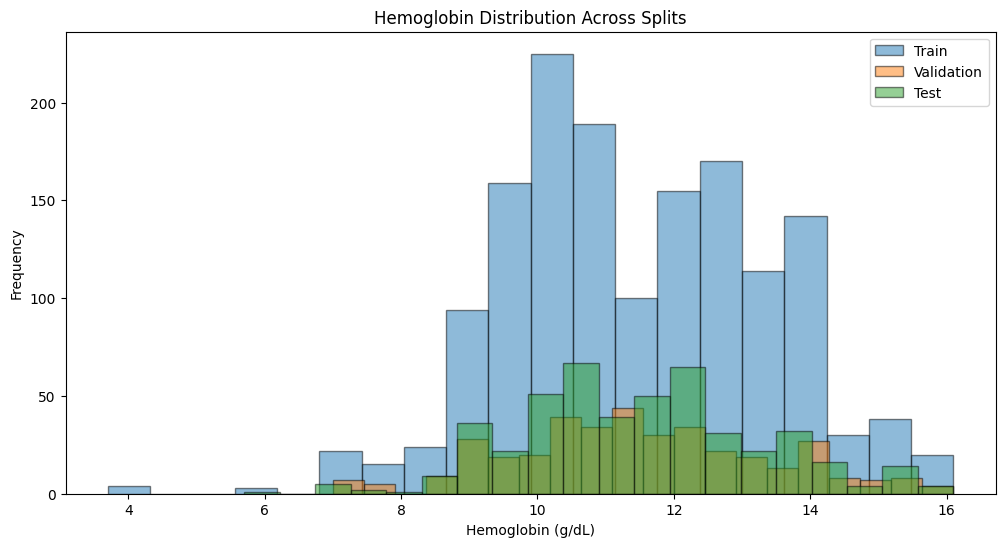

In [ ]:
# Exploring distribution of testing/training set to avoid lackluster training set for low Hg values

import pandas as pd
import matplotlib.pyplot as plt

# Load the splits
save_dir = os.path.dirname(labels_path)
train = pd.read_csv(os.path.join(save_dir, 'train_labels.csv'))
val = pd.read_csv(os.path.join(save_dir, 'val_labels.csv'))
test = pd.read_csv(os.path.join(save_dir, 'test_labels.csv'))

# Plot the distributions
plt.figure(figsize=(12, 6))

# Training set
plt.hist(train['hemoglobin'], bins=20, alpha=0.5, label='Train', edgecolor='black')

# Validation set
plt.hist(val['hemoglobin'], bins=20, alpha=0.5, label='Validation', edgecolor='black')

# Test set
plt.hist(test['hemoglobin'], bins=20, alpha=0.5, label='Test', edgecolor='black')

# Add labels and legend
plt.title('Hemoglobin Distribution Across Splits')
plt.xlabel('Hemoglobin (g/dL)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()


In [ ]:
from ultralytics import YOLO
import os

def process_body_part(model_path, input_folder, output_folder, conf_thresh=0.5):
    """
    Runs a YOLO model to segment images for a specific body part and saves the results.

    Args:
        model_path (str): Path to the YOLO model `.pt` file.
        input_folder (str): Folder containing input images.
        output_folder (str): Folder to save the segmented images.
        conf_thresh (float): Confidence threshold for YOLO predictions.
    """
    # Load the YOLO model
    print(f"Loading YOLO model from {model_path}...")
    model = YOLO(model_path)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Process all images in the input folder
    print(f"Processing images in {input_folder}...")
    results = model(source=input_folder, save=True, conf=conf_thresh, project=output_folder, name="results")

    print(f"Segmentation complete. Results saved in {output_folder}/results/")

# Define paths for each body part
body_parts = {
    "Tongue": {
        "model_path": '/content/drive/My Drive/course data/yolo models/tongue.pt',
        "input_folder": '/content/drive/My Drive/course data/body part combine/Tongue',
        "output_folder": '/content/drive/My Drive/course data/YOLO Images/Tongue'
    }
}

# Process each body part
for part, paths in body_parts.items():
    print(f"\n--- Processing {part} ---")
    try:
      process_body_part(
          model_path=paths["model_path"],
          input_folder=paths["input_folder"],
          output_folder=paths["output_folder"],
          conf_thresh=0.5  # Adjust confidence threshold if needed
      )
    except:
      continue



--- Processing Tongue ---
Loading YOLO model from /content/drive/My Drive/course data/yolo models/tongue.pt...
Processing images in /content/drive/My Drive/course data/body part combine/Tongue...

image 1/427 /content/drive/My Drive/course data/body part combine/Tongue/1709617694248.jpg: 1024x1024 1 tongue, 1 colorcard, 1 blue, 13.3ms
image 2/427 /content/drive/My Drive/course data/body part combine/Tongue/1709617844626.jpg: 1024x1024 1 tongue, 1 colorcard, 1 blue, 13.3ms
image 3/427 /content/drive/My Drive/course data/body part combine/Tongue/1709619191362.jpg: 1024x1024 2 tongues, 1 colorcard, 1 blue, 13.3ms
image 4/427 /content/drive/My Drive/course data/body part combine/Tongue/1709619874657.jpg: 1024x1024 1 tongue, 1 colorcard, 1 blue, 13.3ms
image 5/427 /content/drive/My Drive/course data/body part combine/Tongue/1709620272757.jpg: 1024x1024 1 tongue, 1 colorcard, 1 blue, 18.3ms
image 6/427 /content/drive/My Drive/course data/body part combine/Tongue/1709620787757.jpg: 1024x1024

In [ ]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
from PIL import Image


def process_body_part_with_boxes_and_normalization(
    model_path, input_folder, output_folder, blue_circle_class_name, conf_thresh=0.5, size=(224, 224)
):
    """
    Processes images using YOLO for blue circle detection, normalizes with improved balancing,
    fixes shadows, and overlays segmentation boxes on the output images.

    Args:
        model_path (str): Path to the YOLO model `.pt` file.
        input_folder (str): Folder containing input images.
        output_folder (str): Folder to save processed images.
        blue_circle_class_name (str): Class name for the blue circle (e.g., 'bluecircle', 'blue').
        conf_thresh (float): Confidence threshold for YOLO predictions.
        size (tuple): Target size for resizing (width, height).
    """
    # Load YOLO model
    print(f"Loading YOLO model from {model_path}...")
    model = YOLO(model_path)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Process images
    results = model(source=input_folder, save=False, conf=conf_thresh)

    for result in results:
        image_path = result.path
        image_name = os.path.basename(image_path)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not read image: {image_path}")
            continue

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Normalize using blue circle if available
        normalized_image = image_rgb
        blue_circle_box = None
        for box, cls_id, conf in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy(), result.boxes.conf.cpu().numpy()):
            class_name = result.names[int(cls_id)]
            if class_name == blue_circle_class_name and conf > 0.8:  # Use high-confidence detections
                blue_circle_box = box
                break

        if blue_circle_box is not None and len(blue_circle_box) > 0:
            x_min, y_min, x_max, y_max = map(int, blue_circle_box)
            blue_circle_region = image_rgb[y_min:y_max, x_min:x_max]

            if blue_circle_region.size > 0:
                avg_r, avg_g, avg_b = blue_circle_region.mean(axis=(0, 1))
                avg_r = np.clip(avg_r, 10, 255)
                avg_g = np.clip(avg_g, 10, 255)
                avg_b = np.clip(avg_b, 10, 255)

                # Normalize each channel separately
                normalized_image = image_rgb.astype(np.float32)
                normalized_image[..., 0] /= avg_r  # Red channel
                normalized_image[..., 1] /= avg_g  # Green channel
                normalized_image[..., 2] /= avg_b  # Blue channel

                # Rescale for consistent brightness
                normalized_image *= 128
                normalized_image = np.clip(normalized_image, 0, 255).astype(np.uint8)

                # Apply shadow correction
                normalized_image = fix_shadows(normalized_image)

        # Draw segmentation boxes
        for box, cls_id, conf in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy(), result.boxes.conf.cpu().numpy()):
            class_name = result.names[int(cls_id)]
            x_min, y_min, x_max, y_max = map(int, box)
            color = (0, 255, 0) if class_name != blue_circle_class_name else (255, 0, 0)  # Green for others, Blue for blue circle
            cv2.rectangle(normalized_image, (x_min, y_min), (x_max, y_max), color, 2)
            cv2.putText(
                normalized_image,
                f"{class_name} {conf:.2f}",
                (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2,
            )

        # Resize the image
        resized_image = cv2.resize(normalized_image, size, interpolation=cv2.INTER_AREA)

        # Save the processed image
        output_path = os.path.join(output_folder, image_name)
        Image.fromarray(resized_image).save(output_path)
        print(f"Processed and saved: {output_path}")


def fix_shadows(image):
    """
    Fixes shadows and enhances local contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization).

    Args:
        image (numpy.ndarray): Input RGB image.

    Returns:
        numpy.ndarray: Shadow-corrected image.
    """
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split LAB channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L (lightness) channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge channels back and convert to RGB
    corrected_lab = cv2.merge((l, a, b))
    corrected_image = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2RGB)

    return corrected_image


# Define paths and blue circle class names for each body part
body_parts = {
    "Tongue": {
        "model_path": '/content/drive/My Drive/course data/yolo models/tongue.pt',
        "input_folder": '/content/drive/My Drive/course data/body part combine/Tongue',
        "output_folder": '/content/drive/My Drive/course data/YOLO Images/With Boxes and Normalization/Tongue',
        "blue_circle_class_name": "blue"
    }
}

# Process each body part
for part, paths in body_parts.items():
    print(f"\n--- Processing {part} ---")
    process_body_part_with_boxes_and_normalization(
        model_path=paths["model_path"],
        input_folder=paths["input_folder"],
        output_folder=paths["output_folder"],
        blue_circle_class_name=paths["blue_circle_class_name"],
        conf_thresh=0.5  # Adjust confidence threshold if needed
    )


Streaming output truncated to the last 5000 lines.
image 468/852 /content/drive/My Drive/course data/body part combine/Palm/1709879276017.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 12.6ms
image 469/852 /content/drive/My Drive/course data/body part combine/Palm/1709879280964.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 12.6ms
image 470/852 /content/drive/My Drive/course data/body part combine/Palm/1709879348988.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 12.8ms
image 471/852 /content/drive/My Drive/course data/body part combine/Palm/1709879510271.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 12.8ms
image 472/852 /content/drive/My Drive/course data/body part combine/Palm/1709879549880.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 12.8ms
image 473/852 /content/drive/My Drive/course data/body part combine/Palm/1709879808230.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 12.8ms
image 474/852 /content/drive/My Drive/course data/body part combine/Palm/170987986295

In [ ]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
from PIL import Image
import json


def process_body_part_with_normalization_and_cropping(
    model_path, input_folder, output_folder, output_boxes_file, conf_thresh=0.5, size=(224, 224)
):
    """
    Processes images using YOLO to extract the highest confidence palm,
    applies normalization and resizing, and saves the cropped images.

    Args:
        model_path (str): Path to the YOLO model `.pt` file.
        input_folder (str): Folder containing input images.
        output_folder (str): Folder to save cropped images.
        output_boxes_file (str): Path to save updated bounding box coordinates (JSON format).
        conf_thresh (float): Confidence threshold for YOLO predictions.
        size (tuple): Target size for resizing (width, height).
    """
    print(f"Loading YOLO model from {model_path}...")
    model = YOLO(model_path)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    updated_boxes = {}
    results = model(source=input_folder, save=False, conf=conf_thresh)

    for result in results:
        image_path = result.path
        image_name = os.path.basename(image_path)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not read image: {image_path}")
            continue

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_height, original_width = image_rgb.shape[:2]

        # Find all palm boxes (class ID = 2)
        palm_boxes = [
            {
                "class_id": int(cls_id),
                "confidence": float(conf),
                "box": [int(box[0]), int(box[1]), int(box[2]), int(box[3])]
            }
            for box, cls_id, conf in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy(), result.boxes.conf.cpu().numpy())
            if int(cls_id) == 2  # Only include Palm class (ID 2)
        ]

        if len(palm_boxes) == 0:
            print(f"No palm detected in {image_name}. Skipping...")
            continue

        # Select the highest confidence palm box
        best_palm_box = max(palm_boxes, key=lambda b: b['confidence'])
        x_min, y_min, x_max, y_max = best_palm_box["box"]

        # Crop the palm region
        palm_crop = image_rgb[y_min:y_max, x_min:x_max]
        if palm_crop.size == 0:
            print(f"Empty crop for {image_name}. Skipping...")
            continue

        # Apply normalization (e.g., shadow correction and color balance)
        normalized_palm = normalize_and_fix_shadows(palm_crop)

        # Resize the cropped and normalized image
        resized_palm = cv2.resize(normalized_palm, size, interpolation=cv2.INTER_AREA)

        # Save the cropped and normalized image
        cropped_image_path = os.path.join(output_folder, image_name)
        Image.fromarray(resized_palm).save(cropped_image_path)

        # Update bounding box coordinates relative to the resized image
        crop_width = x_max - x_min
        crop_height = y_max - y_min
        x_scale = size[0] / crop_width
        y_scale = size[1] / crop_height

        updated_boxes[image_name] = [
            {
                "class_id": best_palm_box["class_id"],
                "confidence": best_palm_box["confidence"],
                "box": [
                    int(x_min * x_scale),
                    int(y_min * y_scale),
                    int(x_max * x_scale),
                    int(y_max * y_scale)
                ]
            }
        ]

    # Save all updated bounding boxes to a JSON file
    with open(output_boxes_file, 'w') as f:
        json.dump(updated_boxes, f, indent=4)

    print(f"Processing complete. Cropped and resized images saved to {output_folder}.")
    print(f"Updated bounding boxes saved to {output_boxes_file}.")


def normalize_and_fix_shadows(image):
    """
    Applies normalization and shadow correction to an image.

    Args:
        image (numpy.ndarray): Input cropped image.

    Returns:
        numpy.ndarray: Normalized and shadow-corrected image.
    """
    # Convert to LAB color space for lightness correction
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back LAB channels and convert to RGB
    corrected_lab = cv2.merge((l, a, b))
    corrected_image = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2RGB)

    return corrected_image


# Example usage
body_parts = {
    "Palm": {
        "model_path": '/content/drive/My Drive/course data/yolo models/palm.pt',
        "input_folder": '/content/drive/My Drive/course data/body part combine/Palm',
        "output_folder": '/content/drive/My Drive/course data/Cropped Images/Palm',
        "output_boxes_file": '/content/drive/My Drive/course data/Cropped Images/Palm_boxes.json'
    }
}

for part, paths in body_parts.items():
    print(f"\n--- Processing {part} ---")
    process_body_part_with_normalization_and_cropping(
        model_path=paths["model_path"],
        input_folder=paths["input_folder"],
        output_folder=paths["output_folder"],
        output_boxes_file=paths["output_boxes_file"],
        conf_thresh=0.5,
        size=(224, 224)
    )



--- Processing Palm ---
Loading YOLO model from /content/drive/My Drive/course data/yolo models/palm.pt...

image 1/852 /content/drive/My Drive/course data/body part combine/Palm/1709617238375.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 14.0ms
image 2/852 /content/drive/My Drive/course data/body part combine/Palm/1709617292291.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.3ms
image 3/852 /content/drive/My Drive/course data/body part combine/Palm/1709617534838.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.3ms
image 4/852 /content/drive/My Drive/course data/body part combine/Palm/1709617642044.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.3ms
image 5/852 /content/drive/My Drive/course data/body part combine/Palm/1709618528581.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 14.0ms
image 6/852 /content/drive/My Drive/course data/body part combine/Palm/1709618574207.jpg: 1024x1024 1 colorcard, 1 bluecircle, 1 palm, 13.3ms
image 7/852 /content/drive/My Drive/cou

In [ ]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
from PIL import Image
import json


def process_body_part_with_normalization_and_cropping(
    model_path, input_folder, output_folder, output_boxes_file, class_id=2, conf_thresh=0.5, size=(224, 224)
):
    """
    Processes images using YOLO to extract all instances of the specified class,
    applies normalization and resizing, and saves the cropped images.

    Args:
        model_path (str): Path to the YOLO model `.pt` file.
        input_folder (str): Folder containing input images.
        output_folder (str): Folder to save cropped images.
        output_boxes_file (str): Path to save updated bounding box coordinates (JSON format).
        class_id (int): Target class ID to extract (e.g., 2 for Palm, 1 for Fingernail).
        conf_thresh (float): Confidence threshold for YOLO predictions.
        size (tuple): Target size for resizing (width, height).
    """
    print(f"Loading YOLO model from {model_path}...")
    model = YOLO(model_path)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    updated_boxes = {}
    results = model(source=input_folder, save=False, conf=conf_thresh)

    for result in results:
        image_path = result.path
        image_name = os.path.basename(image_path)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not read image: {image_path}")
            continue

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_height, original_width = image_rgb.shape[:2]

        # Find all instances of the target class
        target_boxes = [
            {
                "class_id": int(cls_id),
                "confidence": float(conf),
                "box": [int(box[0]), int(box[1]), int(box[2]), int(box[3])]
            }
            for box, cls_id, conf in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy(), result.boxes.conf.cpu().numpy())
            if int(cls_id) == class_id  # Only include the target class
        ]

        if len(target_boxes) == 0:
            print(f"No target class detected in {image_name}. Skipping...")
            continue

        # Process each detected box for the target class
        for i, target_box in enumerate(target_boxes):
            x_min, y_min, x_max, y_max = target_box["box"]

            # Crop the target region
            crop = image_rgb[y_min:y_max, x_min:x_max]
            if crop.size == 0:
                print(f"Empty crop for {image_name} (box {i}). Skipping...")
                continue

            # Apply normalization (e.g., shadow correction and color balance)
            normalized_crop = normalize_and_fix_shadows(crop)

            # Resize the cropped and normalized image
            resized_crop = cv2.resize(normalized_crop, size, interpolation=cv2.INTER_AREA)

            # Save the cropped and normalized image with a unique name
            unique_name = f"{os.path.splitext(image_name)[0]}_nail{i + 1}.jpg"  # Include index for uniqueness
            cropped_image_path = os.path.join(output_folder, unique_name)
            Image.fromarray(resized_crop).save(cropped_image_path)

            # Update bounding box coordinates relative to the resized image
            crop_width = x_max - x_min
            crop_height = y_max - y_min
            x_scale = size[0] / crop_width
            y_scale = size[1] / crop_height

            if image_name not in updated_boxes:
                updated_boxes[image_name] = []

            updated_boxes[image_name].append({
                "unique_name": unique_name,
                "class_id": target_box["class_id"],
                "confidence": target_box["confidence"],
                "box": [
                    int(x_min * x_scale),
                    int(y_min * y_scale),
                    int(x_max * x_scale),
                    int(y_max * y_scale)
                ]
            })

    # Save all updated bounding boxes to a JSON file
    with open(output_boxes_file, 'w') as f:
        json.dump(updated_boxes, f, indent=4)

    print(f"Processing complete. Cropped and resized images saved to {output_folder}.")
    print(f"Updated bounding boxes saved to {output_boxes_file}.")


def normalize_and_fix_shadows(image):
    """
    Applies normalization and shadow correction to an image.

    Args:
        image (numpy.ndarray): Input cropped image.

    Returns:
        numpy.ndarray: Normalized and shadow-corrected image.
    """
    # Convert to LAB color space for lightness correction
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back LAB channels and convert to RGB
    corrected_lab = cv2.merge((l, a, b))
    corrected_image = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2RGB)

    return corrected_image


# Example usage
body_parts = {
    "Fingernail": {
        "model_path": '/content/drive/My Drive/course data/yolo models/fingernail.pt',
        "input_folder": '/content/drive/My Drive/course data/body part combine/Fingernail',
        "output_folder": '/content/drive/My Drive/course data/Cropped Images/Fingernail',
        "output_boxes_file": '/content/drive/My Drive/course data/Cropped Images/Fingernail_boxes.json',
        "class_id": 0  # Change to the appropriate class ID for fingernails
    }
}

for part, paths in body_parts.items():
    print(f"\n--- Processing {part} ---")
    process_body_part_with_normalization_and_cropping(
        model_path=paths["model_path"],
        input_folder=paths["input_folder"],
        output_folder=paths["output_folder"],
        output_boxes_file=paths["output_boxes_file"],
        conf_thresh=0.5,
        size=(224, 224),
        class_id=paths["class_id"]
    )



--- Processing Fingernail ---
Loading YOLO model from /content/drive/My Drive/course data/yolo models/fingernail.pt...

image 1/853 /content/drive/My Drive/course data/body part combine/Fingernail/1709617342493.jpg: 1024x1024 6 nails, 1 colorcard, 1 bluecircle, 13.3ms
image 2/853 /content/drive/My Drive/course data/body part combine/Fingernail/1709617374918.jpg: 1024x1024 4 nails, 1 colorcard, 1 bluecircle, 13.3ms
image 3/853 /content/drive/My Drive/course data/body part combine/Fingernail/1709617680583.jpg: 1024x1024 4 nails, 1 colorcard, 1 bluecircle, 13.3ms
image 4/853 /content/drive/My Drive/course data/body part combine/Fingernail/1709617703730.jpg: 1024x1024 4 nails, 1 colorcard, 1 bluecircle, 13.2ms
image 5/853 /content/drive/My Drive/course data/body part combine/Fingernail/1709618619330.jpg: 1024x1024 4 nails, 1 colorcard, 1 bluecircle, 13.2ms
image 6/853 /content/drive/My Drive/course data/body part combine/Fingernail/1709618658975.jpg: 1024x1024 4 nails, 1 colorcard, 1 blue

In [ ]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
from PIL import Image
import json


def process_eye_with_normalization_and_cropping(
    model_path, input_folder, output_folder, output_boxes_file, class_id=3, conf_thresh=0.5, size=(224, 224)
):
    """
    Processes images using YOLO to extract the highest confidence eye,
    applies normalization and resizing, and saves the cropped images.

    Args:
        model_path (str): Path to the YOLO model `.pt` file.
        input_folder (str): Folder containing input images.
        output_folder (str): Folder to save cropped images.
        output_boxes_file (str): Path to save updated bounding box coordinates (JSON format).
        class_id (int): Target class ID to extract (e.g., 3 for Eye).
        conf_thresh (float): Confidence threshold for YOLO predictions.
        size (tuple): Target size for resizing (width, height).
    """
    print(f"Loading YOLO model from {model_path}...")
    model = YOLO(model_path)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    updated_boxes = {}
    results = model(source=input_folder, save=False, conf=conf_thresh)

    for result in results:
        image_path = result.path
        image_name = os.path.basename(image_path)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Could not read image: {image_path}")
            continue

        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_height, original_width = image_rgb.shape[:2]

        # Find all eye boxes (class ID = 3)
        eye_boxes = [
            {
                "class_id": int(cls_id),
                "confidence": float(conf),
                "box": [int(box[0]), int(box[1]), int(box[2]), int(box[3])]
            }
            for box, cls_id, conf in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy(), result.boxes.conf.cpu().numpy())
            if int(cls_id) == class_id  # Only include Eye class (ID 3)
        ]

        if len(eye_boxes) == 0:
            print(f"No eye detected in {image_name}. Skipping...")
            continue

        # Select the highest confidence eye box
        best_eye_box = max(eye_boxes, key=lambda b: b['confidence'])
        x_min, y_min, x_max, y_max = best_eye_box["box"]

        # Crop the eye region
        eye_crop = image_rgb[y_min:y_max, x_min:x_max]
        if eye_crop.size == 0:
            print(f"Empty crop for {image_name}. Skipping...")
            continue

        # Apply normalization (e.g., shadow correction and color balance)
        normalized_eye = normalize_and_fix_shadows(eye_crop)

        # Resize the cropped and normalized image
        resized_eye = cv2.resize(normalized_eye, size, interpolation=cv2.INTER_AREA)

        # Save the cropped and normalized image
        cropped_image_path = os.path.join(output_folder, image_name)
        Image.fromarray(resized_eye).save(cropped_image_path)

        # Update bounding box coordinates relative to the resized image
        crop_width = x_max - x_min
        crop_height = y_max - y_min
        x_scale = size[0] / crop_width
        y_scale = size[1] / crop_height

        updated_boxes[image_name] = [
            {
                "class_id": best_eye_box["class_id"],
                "confidence": best_eye_box["confidence"],
                "box": [
                    int(x_min * x_scale),
                    int(y_min * y_scale),
                    int(x_max * x_scale),
                    int(y_max * y_scale)
                ]
            }
        ]

    # Save all updated bounding boxes to a JSON file
    with open(output_boxes_file, 'w') as f:
        json.dump(updated_boxes, f, indent=4)

    print(f"Processing complete. Cropped and resized images saved to {output_folder}.")
    print(f"Updated bounding boxes saved to {output_boxes_file}.")


def normalize_and_fix_shadows(image):
    """
    Applies normalization and shadow correction to an image.

    Args:
        image (numpy.ndarray): Input cropped image.

    Returns:
        numpy.ndarray: Normalized and shadow-corrected image.
    """
    # Convert to LAB color space for lightness correction
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back LAB channels and convert to RGB
    corrected_lab = cv2.merge((l, a, b))
    corrected_image = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2RGB)

    return corrected_image


# Example usage
body_parts = {
    "Eye": {
        "model_path": '/content/drive/My Drive/course data/yolo models/eye.pt',
        "input_folder": '/content/drive/My Drive/course data/body part combine/Eye',
        "output_folder": '/content/drive/My Drive/course data/Cropped Images/Eye',
        "output_boxes_file": '/content/drive/My Drive/course data/Cropped Images/Eye_boxes.json',
        "class_id": 0  # Change to the appropriate class ID for eyes
    }
}

for part, paths in body_parts.items():
    print(f"\n--- Processing {part} ---")
    process_eye_with_normalization_and_cropping(
        model_path=paths["model_path"],
        input_folder=paths["input_folder"],
        output_folder=paths["output_folder"],
        output_boxes_file=paths["output_boxes_file"],
        conf_thresh=0.5,
        size=(224, 224),
        class_id=paths["class_id"]
    )



--- Processing Eye ---
Loading YOLO model from /content/drive/My Drive/course data/yolo models/eye.pt...

image 1/852 /content/drive/My Drive/course data/body part combine/Eye/1709617490220.jpg: 640x640 1 eye, 84.0ms
image 2/852 /content/drive/My Drive/course data/body part combine/Eye/1709617535926.jpg: 640x640 1 eye, 81.3ms
image 3/852 /content/drive/My Drive/course data/body part combine/Eye/1709617782204.jpg: 640x640 1 eye, 68.3ms
image 4/852 /content/drive/My Drive/course data/body part combine/Eye/1709617820897.jpg: 640x640 1 eye, 68.4ms
image 5/852 /content/drive/My Drive/course data/body part combine/Eye/1709618916134.jpg: 640x640 1 eye, 69.3ms
image 6/852 /content/drive/My Drive/course data/body part combine/Eye/1709619099298.jpg: 640x640 1 eye, 67.7ms
image 7/852 /content/drive/My Drive/course data/body part combine/Eye/1709619661748.jpg: 640x640 1 eye, 68.9ms
image 8/852 /content/drive/My Drive/course data/body part combine/Eye/1709619693768.jpg: 640x640 1 eye, 67.2ms
image

In [ ]:
from ultralytics import YOLO
import os
import cv2
import numpy as np
from PIL import Image
import json


def process_tongue_with_normalization_and_cropping(
    model_path, input_folder, output_folder, output_boxes_file, class_id=4, conf_thresh=0.5, size=(224, 224), batch_size=200
):
    """
    Processes images using YOLO to extract the highest confidence tongue,
    applies normalization and resizing, and saves the cropped images in batches.

    Args:
        model_path (str): Path to the YOLO model `.pt` file.
        input_folder (str): Folder containing input images.
        output_folder (str): Folder to save cropped images.
        output_boxes_file (str): Path to save updated bounding box coordinates (JSON format).
        class_id (int): Target class ID to extract (e.g., 4 for Tongue).
        conf_thresh (float): Confidence threshold for YOLO predictions.
        size (tuple): Target size for resizing (width, height).
        batch_size (int): Number of images to process in one batch.
    """
    print(f"Loading YOLO model from {model_path}...")
    model = YOLO(model_path)

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Load all images from the input folder
    image_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    total_images = len(image_files)
    print(f"Found {total_images} images. Processing in batches of {batch_size}.")

    updated_boxes = {}

    # Process images in batches
    for i in range(0, total_images, batch_size):
        batch_files = image_files[i:i + batch_size]
        print(f"Processing batch {i // batch_size + 1} ({len(batch_files)} images)...")

        results = model(source=batch_files, save=False, conf=conf_thresh)

        for result in results:
            image_path = result.path
            image_name = os.path.basename(image_path)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Could not read image: {image_path}")
                continue

            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            original_height, original_width = image_rgb.shape[:2]

            # Find all tongue boxes (class ID = 4)
            tongue_boxes = [
                {
                    "class_id": int(cls_id),
                    "confidence": float(conf),
                    "box": [int(box[0]), int(box[1]), int(box[2]), int(box[3])]
                }
                for box, cls_id, conf in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy(), result.boxes.conf.cpu().numpy())
                if int(cls_id) == class_id  # Only include Tongue class (ID 4)
            ]

            if len(tongue_boxes) == 0:
                print(f"No tongue detected in {image_name}. Skipping...")
                continue

            # Select the highest confidence tongue box
            best_tongue_box = max(tongue_boxes, key=lambda b: b['confidence'])
            x_min, y_min, x_max, y_max = best_tongue_box["box"]

            # Crop the tongue region
            tongue_crop = image_rgb[y_min:y_max, x_min:x_max]
            if tongue_crop.size == 0:
                print(f"Empty crop for {image_name}. Skipping...")
                continue

            # Apply normalization (e.g., shadow correction and color balance)
            normalized_tongue = normalize_and_fix_shadows(tongue_crop)

            # Resize the cropped and normalized image
            resized_tongue = cv2.resize(normalized_tongue, size, interpolation=cv2.INTER_AREA)

            # Save the cropped and normalized image
            cropped_image_name = f"{os.path.splitext(image_name)[0]}_tongue_{i}.jpg"  # Unique naming for tongue
            cropped_image_path = os.path.join(output_folder, cropped_image_name)
            Image.fromarray(resized_tongue).save(cropped_image_path)

            # Update bounding box coordinates relative to the resized image
            crop_width = x_max - x_min
            crop_height = y_max - y_min
            x_scale = size[0] / crop_width
            y_scale = size[1] / crop_height

            updated_boxes[image_name] = [
                {
                    "class_id": best_tongue_box["class_id"],
                    "confidence": best_tongue_box["confidence"],
                    "box": [
                        int(x_min * x_scale),
                        int(y_min * y_scale),
                        int(x_max * x_scale),
                        int(y_max * y_scale)
                    ]
                }
            ]

    # Save all updated bounding boxes to a JSON file
    with open(output_boxes_file, 'w') as f:
        json.dump(updated_boxes, f, indent=4)

    print(f"Processing complete. Cropped and resized images saved to {output_folder}.")
    print(f"Updated bounding boxes saved to {output_boxes_file}.")


def normalize_and_fix_shadows(image):
    """
    Applies normalization and shadow correction to an image.

    Args:
        image (numpy.ndarray): Input cropped image.

    Returns:
        numpy.ndarray: Normalized and shadow-corrected image.
    """
    # Convert to LAB color space for lightness correction
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to lightness channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back LAB channels and convert to RGB
    corrected_lab = cv2.merge((l, a, b))
    corrected_image = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2RGB)

    return corrected_image


# Example usage
body_parts = {
    "Tongue": {
        "model_path": '/content/drive/My Drive/course data/yolo models/tongue.pt',
        "input_folder": '/content/drive/My Drive/course data/body part combine/Tongue',
        "output_folder": '/content/drive/My Drive/course data/Cropped Images/Tongue',
        "output_boxes_file": '/content/drive/My Drive/course data/Cropped Images/Tongue_boxes.json',
        "class_id": 0  # Change to the appropriate class ID for tongue
    }
}

for part, paths in body_parts.items():
    print(f"\n--- Processing {part} ---")
    process_tongue_with_normalization_and_cropping(
        model_path=paths["model_path"],
        input_folder=paths["input_folder"],
        output_folder=paths["output_folder"],
        output_boxes_file=paths["output_boxes_file"],
        conf_thresh=0.5,
        size=(224, 224),
        class_id=paths["class_id"],
        batch_size=100  # Adjust the batch size to manage memory
    )



--- Processing Tongue ---
Loading YOLO model from /content/drive/My Drive/course data/yolo models/tongue.pt...
Found 427 images. Processing in batches of 100.
Processing batch 1 (100 images)...

0: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
1: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
2: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
3: 1024x1024 1 colorcard, 1 blue, 8.8ms
4: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
5: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
6: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
7: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
8: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
9: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
10: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
11: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
12: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
13: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
14: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
15: 1024x1024 1 tongue, 1 colorcard, 1 blue, 8.8ms
16: 1024